In [4]:
from datasets import load_dataset
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

In [5]:
import re
import pandas as pd

def normalize_for_dedup(text: str) -> str:
    """
    Aggressive normalization for comparison only:
    - lowercase
    - remove literal backslash escapes like '\n', '\r', '\t'
    - remove ALL non-word characters (punctuation, spaces, tabs, newlines, etc.)
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    t = re.sub(r"\\[nrt]", "", t)          # remove \n, \r, \t literals
    t = re.sub(r"\W+", "", t, flags=re.UNICODE)
    return t

def is_meta_only_setup(text: str) -> bool:
    """Return True if the whole setup is just TL;DR, NSFW label, link, etc."""
    if not isinstance(text, str):
        return True  # treat NaN as bad
    t = text.strip()
    if not t:
        return True

    # TL;DR only (variants: tl;dr, tl:dr:, etc.)
    if re.fullmatch(r'(?i)tl;?\s*dr:?', t):
        return True

    # NSFW labels only: "NSFW", "[NSFW]", "(nsfw)" etc.
    if re.fullmatch(r'(?i)[\[\(]*\s*nsfw\s*[\]\)]*', t):
        return True

    # bare http / https or www link
    if re.fullmatch(r'(https?://\S+|www\.\S+)', t, flags=re.IGNORECASE):
        return True

    # bare subreddit or similar: "r/funny"
    if re.fullmatch(r'(?i)r/\S+', t):
        return True

    return False


def apply_setup_filters(df: pd.DataFrame,
                        min_chars: int = 3,
                        max_chars: int = 256,
                        max_punchline_chars: int = 128) -> pd.DataFrame:
    # ----- setup-based filters -----
    s = df["setup"].fillna("")

    # 1) meta-only setups
    mask_meta = s.apply(is_meta_only_setup)

    # 2) too long setups
    mask_long_setup = s.str.len() > max_chars

    # 3) too short / only punctuation setups
    #    remove all non-alphanumeric characters and see what is left
    alnum = s.str.replace(r"[^0-9A-Za-z]+", "", regex=True)
    mask_short = alnum.str.len() < min_chars

    # ----- punchline length filter -----
    cp = df["chosen_punchline"].fillna("")
    rp = df["rejected_punchline"].fillna("")

    mask_long_punch = (cp.str.len() > max_punchline_chars) | (rp.str.len() > max_punchline_chars)

    # ----- combine -----
    mask_drop = mask_meta | mask_long_setup | mask_short | mask_long_punch

    print("Total rows:", len(df))
    print("  meta-only setups dropped      :", mask_meta.sum())
    print("  too long setups dropped       :", mask_long_setup.sum())
    print("  too short / punct. dropped    :", mask_short.sum())
    print("  long punchlines (> {}) dropped: {}".format(
        max_punchline_chars, mask_long_punch.sum()))
    print("  total dropped                 :", mask_drop.sum())

    return df[~mask_drop].reset_index(drop=True)



def merge_with_priority(better: pd.DataFrame,
                        worse: pd.DataFrame) -> pd.DataFrame:
    better = better.copy()
    worse = worse.copy()

    better["setup_norm"] = better["setup"].map(normalize_for_dedup)
    worse["setup_norm"]  = worse["setup"].map(normalize_for_dedup)

    mask_new = ~worse["setup_norm"].isin(better["setup_norm"])
    worse_new = worse[mask_new]

    merged = pd.concat([better, worse_new], ignore_index=True)
    merged = merged.drop(columns=["setup_norm"])

    return merged


In [6]:
third = pd.read_csv('../data/generated_data/third_set_dpo.csv')
dad = pd.read_csv('../data/generated_data/dad_jokes_dpo_pairs.csv')
million = pd.read_csv('../data/generated_data/pairs_dpo_one_million.csv')

In [7]:
dad_f    = apply_setup_filters(dad)
third_f  = apply_setup_filters(third)
million_f = apply_setup_filters(million)


Total rows: 782
  meta-only setups dropped      : 0
  too long setups dropped       : 2
  too short / punct. dropped    : 0
  long punchlines (> 128) dropped: 36
  total dropped                 : 36
Total rows: 9348
  meta-only setups dropped      : 0
  too long setups dropped       : 0
  too short / punct. dropped    : 0
  long punchlines (> 128) dropped: 127
  total dropped                 : 127
Total rows: 8597
  meta-only setups dropped      : 0
  too long setups dropped       : 0
  too short / punct. dropped    : 0
  long punchlines (> 128) dropped: 2868
  total dropped                 : 2868


In [8]:
merged_1 = merge_with_priority(dad_f, third_f)

merged_all = merge_with_priority(merged_1, million_f)

print("After merging:")
print("  dad_f rows     :", len(dad_f))
print("  third_f rows   :", len(third_f))
print("  million_f rows :", len(million_f))
print("  merged_all rows:", len(merged_all))

After merging:
  dad_f rows     : 746
  third_f rows   : 9221
  million_f rows : 5729
  merged_all rows: 15182


In [9]:
merged_all

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,A blind man walks into a bar,And a chair and a table,"He said ""ouch"", then walked into a club, and s...",22.0,5.0
1,A book just fell on my head.,I've only got myshelf to blame.,I only have my shelf to blame.,43.0,14.0
2,A guy walked into a bar,And was disqualified from the limbo contest.,Ouch!,3420.0,10.0
3,A ham sandwich walks into a bar and orders a b...,"The bartender says, ""Sorry we don’t serve food...","The bartender says, ""I'm sorry, we don't serve...",98.0,12.0
4,A horse walks into a bar,"The bartender says ""hey"" \n.\n.\nThe horse rep...",That’s gonna be a ten-point deduction,846.0,14.0
...,...,...,...,...,...
15177,Your momma's so fat...,"she doesn't go back for seconds, she goes back...",A Stormtrooper could hit her with a blaster shot.,167.0,67.0
15178,Your momma's so fat....,She got put on whalefare,She saw a yellow bus full of white kids and sc...,18.0,6.0
15179,Your mother is so fat,That she was sent home for gathering in a publ...,Her chins wear suspenders. \n\n(Hope its origi...,25.0,13.0
15180,"“Dad, is the Fibonacci sequence hard to unders...","“Nope. It’s as easy as 1,1,2,3.”","Dad: No, it’s as easy as 1,1,2,3.",116.0,8.0


In [10]:
merged_all["setup_norm"] = merged_all["setup"].map(normalize_for_dedup)
merged_all = (
    merged_all
    .drop_duplicates("setup_norm", keep="first")
    .drop(columns=["setup_norm"])
    .reset_index(drop=True)
)

print("Final rows after dedup by setup_norm:", len(merged_all))

Final rows after dedup by setup_norm: 12824


In [11]:
merged_all

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,A blind man walks into a bar,And a chair and a table,"He said ""ouch"", then walked into a club, and s...",22.0,5.0
1,A book just fell on my head.,I've only got myshelf to blame.,I only have my shelf to blame.,43.0,14.0
2,A guy walked into a bar,And was disqualified from the limbo contest.,Ouch!,3420.0,10.0
3,A ham sandwich walks into a bar and orders a b...,"The bartender says, ""Sorry we don’t serve food...","The bartender says, ""I'm sorry, we don't serve...",98.0,12.0
4,A horse walks into a bar,"The bartender says ""hey"" \n.\n.\nThe horse rep...",That’s gonna be a ten-point deduction,846.0,14.0
...,...,...,...,...,...
12819,Your momma so fat,It's been four weeks since Thanos snapped his ...,she is almost as fat as my mom,123.0,5.0
12820,Your momma's so fat,Thanos had to clap,She gives off Hawking radiation,145.0,22.0
12821,Your mother is so fat,That she was sent home for gathering in a publ...,Her chins wear suspenders. \n\n(Hope its origi...,25.0,13.0
12822,"“Dad, is the Fibonacci sequence hard to unders...","“Nope. It’s as easy as 1,1,2,3.”","Dad: No, it’s as easy as 1,1,2,3.",116.0,8.0


In [12]:
merged_all.to_csv("./data/generated_data/dpo_final_set.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'data/generated_data'

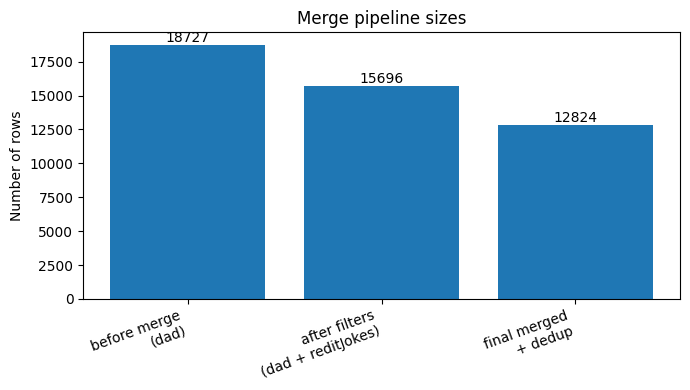

In [16]:
import matplotlib.pyplot as plt

before_total = len(dad) + len(third) + len(million)
after_filters_total = len(dad_f) + len(third_f) + len(million_f)
final_total = len(merged_all)

stage_names = ["before merge\n(dad)", "after filters\n(dad + reditJokes)", "final merged\n+ dedup"]
counts = [before_total, after_filters_total, final_total]

plt.figure(figsize=(7, 4))
plt.bar(stage_names, counts)
plt.title("Merge pipeline sizes")
plt.ylabel("Number of rows")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()
